# Notebook 04 — Model Training & Evaluation

Train and compare **6 models** on **4 dataset variants × 2 tasks** using **5-fold cross-validation**, with per-model visualizations and hyperparameter tuning.

| # | Classification (Profit) | Regression (Vote) |
|---|---|---|
| 1 | Logistic Regression | Linear Regression |
| 2 | Decision Tree | Decision Tree |
| 3 | Random Forest | Random Forest |
| 4 | KNN | KNN |
| 5 | Gradient Boosting | Gradient Boosting |
| 6 | SVM | SVR |

| Dataset Variant | Key |
|---|---|
| Metadata Only | `metadata_only` |
| Meta + Credits | `meta_+_credits` |
| Meta + Keywords | `meta_+_keywords` |
| All Combined | `all_combined` |

**New:** Ensemble averaging for regression — average predictions from top-N regressors as a final model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib, time
from sklearn.base import clone

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                               GradientBoostingClassifier, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110
print("Libraries loaded.")

Libraries loaded.


## 1 · Load All Dataset Splits (Profit & Vote)

In [3]:
VARIANTS = ['metadata_only', 'meta_+_credits', 'meta_+_keywords', 'all_combined']
VARIANT_LABELS = {
    'metadata_only':   'Metadata Only',
    'meta_+_credits':  'Meta + Credits',
    'meta_+_keywords': 'Meta + Keywords',
    'all_combined':    'All Combined',
}
PROFIT_DIR = '../data/processed/profit'
VOTE_DIR   = '../data/processed/vote'
COLORS = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

# ---- Load Profit (Classification) splits ----
profit = {}
print("PROFIT (Classification) splits")
print("-" * 65)
for v in VARIANTS:
    p = f'{PROFIT_DIR}/{v}'
    profit[v] = {
        'X_train': pd.read_csv(f'{p}/X_train_clf.csv'),
        'X_test':  pd.read_csv(f'{p}/X_test_clf.csv'),
        'y_train': pd.read_csv(f'{p}/y_train_clf.csv').squeeze(),
        'y_test':  pd.read_csv(f'{p}/y_test_clf.csv').squeeze(),
    }
    d = profit[v]
    print(f"  {VARIANT_LABELS[v]:20s}  Train: {d['X_train'].shape}  Test: {d['X_test'].shape}")

# ---- Load Vote (Regression) splits ----
vote = {}
print(f"\nVOTE (Regression) splits")
print("-" * 65)
for v in VARIANTS:
    p = f'{VOTE_DIR}/{v}'
    vote[v] = {
        'X_train': pd.read_csv(f'{p}/X_train_reg.csv'),
        'X_test':  pd.read_csv(f'{p}/X_test_reg.csv'),
        'y_train': pd.read_csv(f'{p}/y_train_reg.csv').squeeze(),
        'y_test':  pd.read_csv(f'{p}/y_test_reg.csv').squeeze(),
    }
    d = vote[v]
    print(f"  {VARIANT_LABELS[v]:20s}  Train: {d['X_train'].shape}  Test: {d['X_test'].shape}")

PROFIT (Classification) splits
-----------------------------------------------------------------
  Metadata Only         Train: (4287, 33)  Test: (1072, 33)
  Meta + Credits        Train: (4287, 36)  Test: (1072, 36)
  Meta + Keywords       Train: (4287, 34)  Test: (1072, 34)
  All Combined          Train: (4287, 36)  Test: (1072, 36)

VOTE (Regression) splits
-----------------------------------------------------------------
  Metadata Only         Train: (32643, 33)  Test: (8161, 33)
  Meta + Credits        Train: (32643, 35)  Test: (8161, 35)
  Meta + Keywords       Train: (32643, 34)  Test: (8161, 34)
  All Combined          Train: (32643, 36)  Test: (8161, 36)


---
## 2 · Classification — Predict `profitable`

### 2.1 · Cross-Validate All Models on All Dataset Variants

In [4]:
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree':       DecisionTreeClassifier(random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                 KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM':                 SVC(kernel='rbf', probability=True, random_state=42),
}

all_cv_clf = {}
for v in VARIANTS:
    Xtr, ytr = profit[v]['X_train'], profit[v]['y_train']
    print(f"\n--- {VARIANT_LABELS[v]} ({Xtr.shape[1]} features) ---")
    print(f"{'Model':<25} {'Accuracy':>10} {'F1':>10} {'ROC-AUC':>10}  Time")
    print("-" * 68)

    cv_res = {}
    for name, model in clf_models.items():
        t0 = time.time()
        acc = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='accuracy')
        f1  = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='f1')
        auc = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='roc_auc')
        elapsed = time.time() - t0

        cv_res[name] = {
            'accuracy': acc.mean(), 'f1': f1.mean(), 'roc_auc': auc.mean(),
            'acc_std': acc.std(), 'f1_std': f1.std(), 'auc_std': auc.std(),
        }
        print(f"{name:<25} {acc.mean():.4f}±{acc.std():.3f}"
              f" {f1.mean():.4f}±{f1.std():.3f}"
              f" {auc.mean():.4f}±{auc.std():.3f}"
              f"  {elapsed:.1f}s")
    all_cv_clf[v] = cv_res


--- Metadata Only (33 features) ---
Model                       Accuracy         F1    ROC-AUC  Time
--------------------------------------------------------------------
Logistic Regression       0.7737±0.004 0.8446±0.003 0.8254±0.015  0.1s
Decision Tree             0.7115±0.011 0.7925±0.008 0.6604±0.016  0.3s
Random Forest             0.7847±0.007 0.8534±0.005 0.8368±0.017  2.3s
KNN                       0.7154±0.018 0.8055±0.013 0.7137±0.025  3.4s
Gradient Boosting         0.7854±0.011 0.8526±0.008 0.8417±0.014  6.6s
SVM                       0.7490±0.013 0.8355±0.010 0.7923±0.017  14.6s

--- Meta + Credits (36 features) ---
Model                       Accuracy         F1    ROC-AUC  Time
--------------------------------------------------------------------
Logistic Regression       0.7761±0.007 0.8460±0.005 0.8256±0.015  0.1s
Decision Tree             0.7117±0.009 0.7925±0.006 0.6613±0.011  0.3s
Random Forest             0.7854±0.007 0.8546±0.005 0.8356±0.016  2.1s
KNN              

### 2.2 · CV Results Comparison

BEST CLASSIFIER PER DATASET (by CV F1)
        Dataset    Best Model  CV Accuracy  CV F1  CV ROC-AUC
  Metadata Only Random Forest       0.7847 0.8534      0.8368
 Meta + Credits Random Forest       0.7854 0.8546      0.8356
Meta + Keywords Random Forest       0.7817 0.8524      0.8357
   All Combined Random Forest       0.7854 0.8546      0.8356


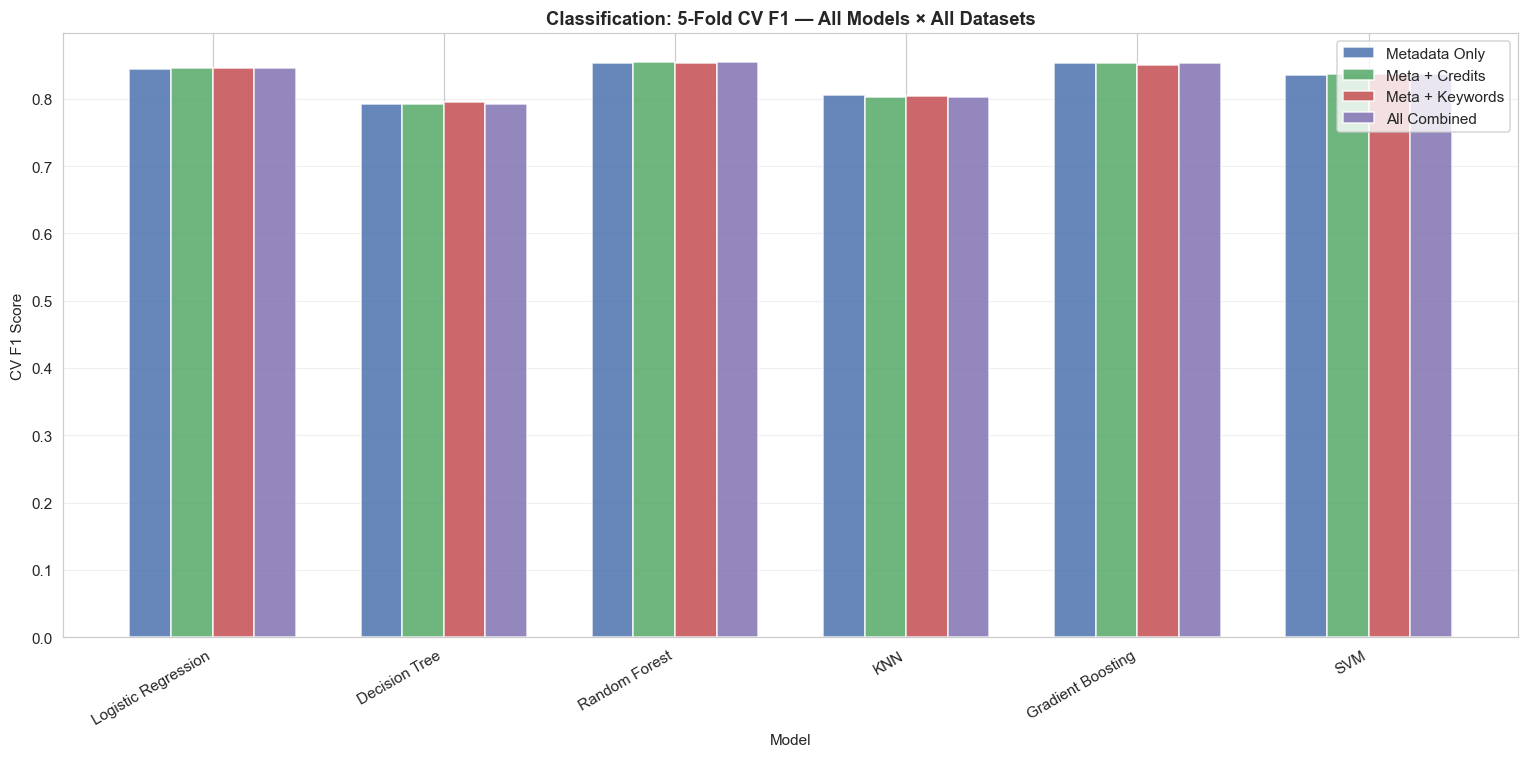

In [5]:
# Best model per dataset (by CV F1)
best_clf_cv = []
for v in VARIANTS:
    cv_res = all_cv_clf[v]
    best_name = max(cv_res, key=lambda m: cv_res[m]['f1'])
    best = cv_res[best_name]
    best_clf_cv.append({
        'Dataset': VARIANT_LABELS[v], 'Best Model': best_name,
        'CV Accuracy': round(best['accuracy'], 4),
        'CV F1': round(best['f1'], 4), 'CV ROC-AUC': round(best['roc_auc'], 4),
    })

print("BEST CLASSIFIER PER DATASET (by CV F1)")
print("=" * 80)
print(pd.DataFrame(best_clf_cv).to_string(index=False))

# Grouped bar chart: F1 of all models across datasets
fig, ax = plt.subplots(figsize=(14, 7))
model_names = list(clf_models.keys())
x = np.arange(len(model_names))
width = 0.18

for i, v in enumerate(VARIANTS):
    f1_vals = [all_cv_clf[v][m]['f1'] for m in model_names]
    ax.bar(x + i * width, f1_vals, width, label=VARIANT_LABELS[v], color=COLORS[i], alpha=0.85)

ax.set_xlabel('Model')
ax.set_ylabel('CV F1 Score')
ax.set_title('Classification: 5-Fold CV F1 — All Models × All Datasets', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names, rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 · Test Set Evaluation — Per-Model Metrics

In [6]:
# Train on full train set, evaluate on test set — store fitted models
all_test_clf = {}
fitted_clf = {}   # store fitted models for later viz

for v in VARIANTS:
    Xtr, Xte = profit[v]['X_train'], profit[v]['X_test']
    ytr, yte = profit[v]['y_train'], profit[v]['y_test']

    test_res = {}
    fitted_clf[v] = {}
    for name, model in clf_models.items():
        m = clone(model)
        m.fit(Xtr, ytr)
        y_pred = m.predict(Xte)
        y_prob = m.predict_proba(Xte)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(Xte)

        test_res[name] = {
            'accuracy': accuracy_score(yte, y_pred),
            'precision': precision_score(yte, y_pred),
            'recall': recall_score(yte, y_pred),
            'f1': f1_score(yte, y_pred),
            'roc_auc': roc_auc_score(yte, y_prob),
        }
        fitted_clf[v][name] = {'model': m, 'y_pred': y_pred, 'y_prob': y_prob}
    all_test_clf[v] = test_res

# Print results per dataset
for v in VARIANTS:
    print(f"\n--- {VARIANT_LABELS[v]} ---")
    test_df = pd.DataFrame(all_test_clf[v]).T
    test_df = test_df.sort_values('f1', ascending=False)
    print(test_df.round(4).to_string())


--- Metadata Only ---
                     accuracy  precision  recall      f1  roc_auc
Random Forest          0.7910     0.8159  0.9052  0.8582   0.8575
Gradient Boosting      0.7864     0.8171  0.8945  0.8540   0.8540
Logistic Regression    0.7826     0.8162  0.8892  0.8511   0.8445
SVM                    0.7640     0.7805  0.9212  0.8451   0.8258
KNN                    0.7257     0.7791  0.8478  0.8120   0.7362
Decision Tree          0.7351     0.8138  0.8051  0.8094   0.6889

--- Meta + Credits ---
                     accuracy  precision  recall      f1  roc_auc
Random Forest          0.7976     0.8236  0.9039  0.8619   0.8512
Gradient Boosting      0.7799     0.8109  0.8932  0.8501   0.8551
Logistic Regression    0.7780     0.8150  0.8825  0.8474   0.8435
SVM                    0.7612     0.7748  0.9279  0.8445   0.8227
Decision Tree          0.7388     0.8114  0.8158  0.8136   0.6881
KNN                    0.7146     0.7691  0.8451  0.8053   0.7134

--- Meta + Keywords ---
    

### 2.4 · Per-Model Visualizations — Confusion Matrices & ROC Curves

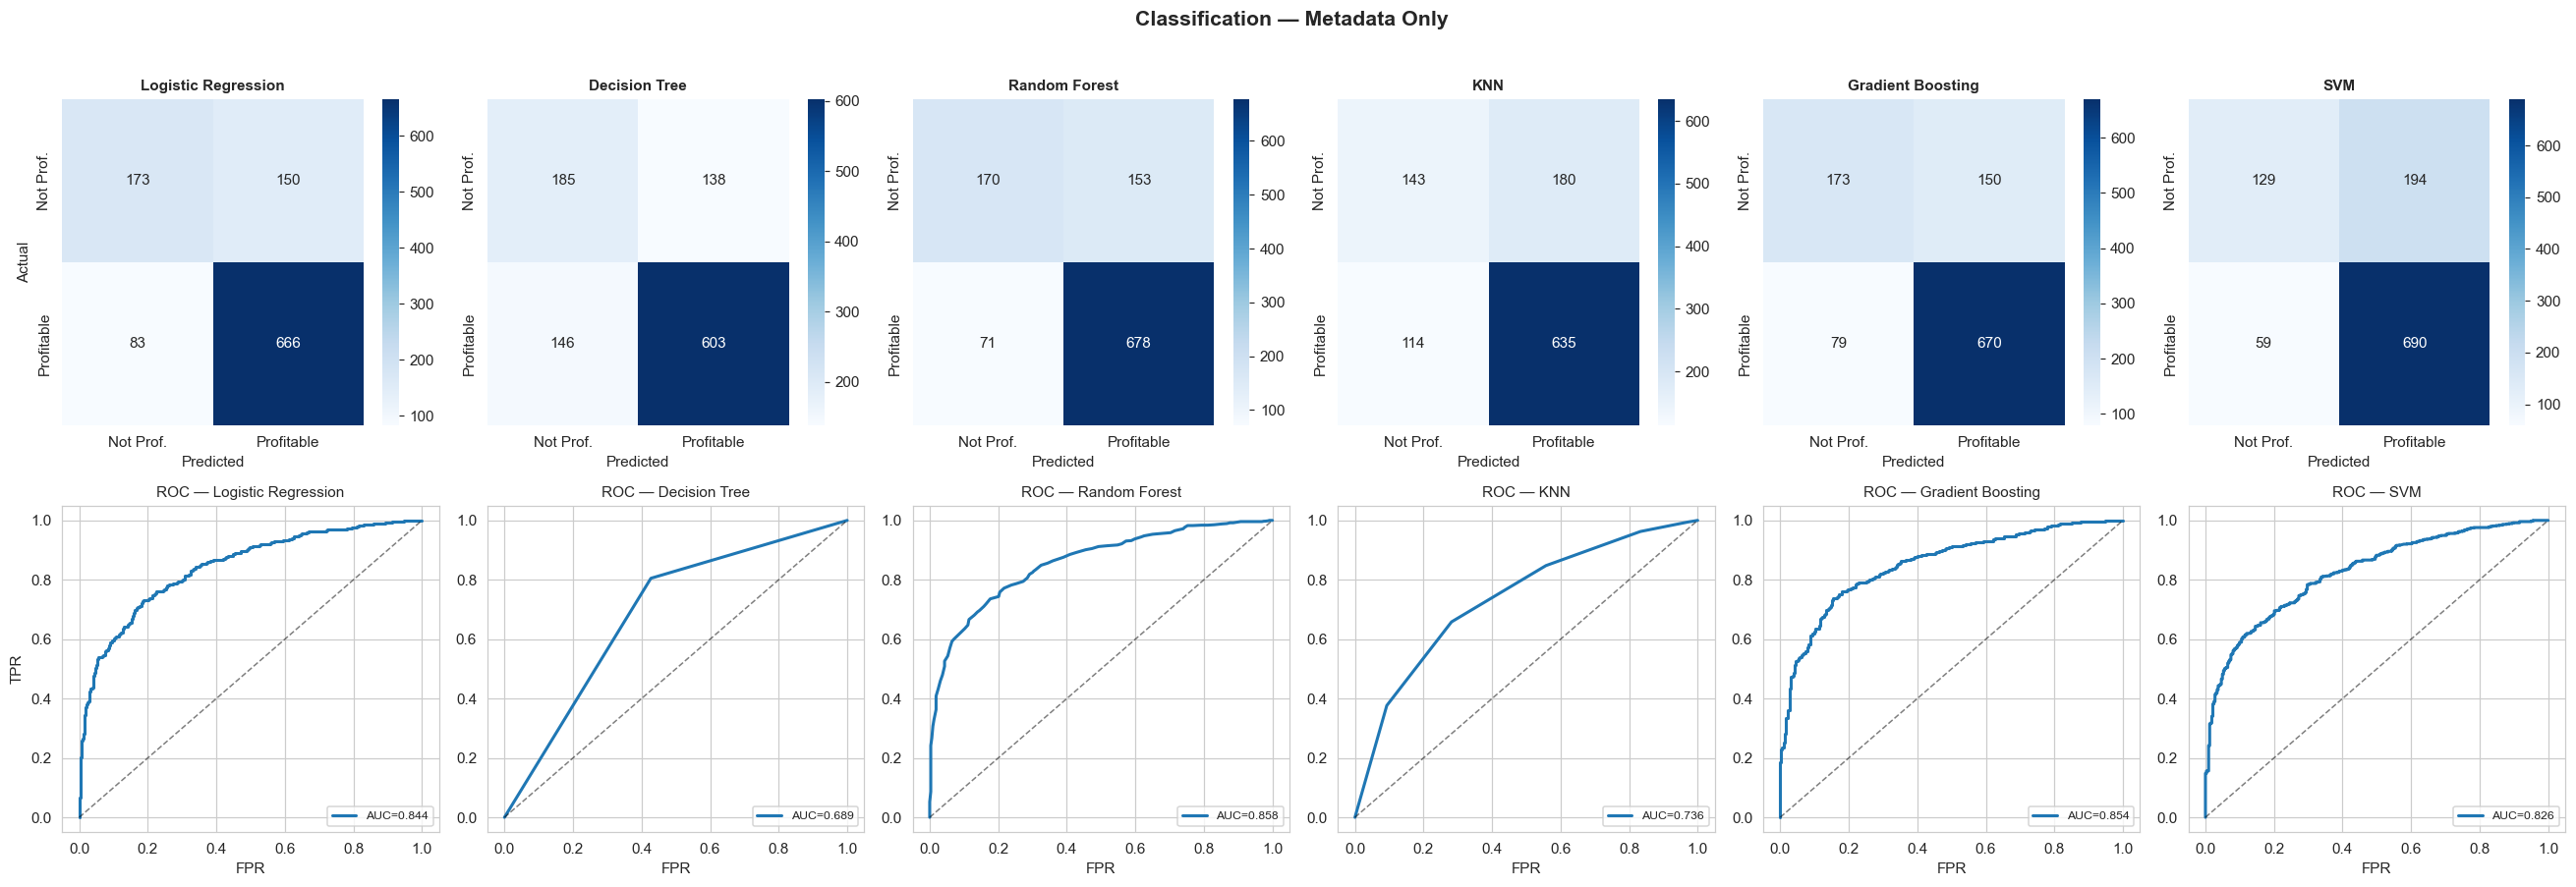

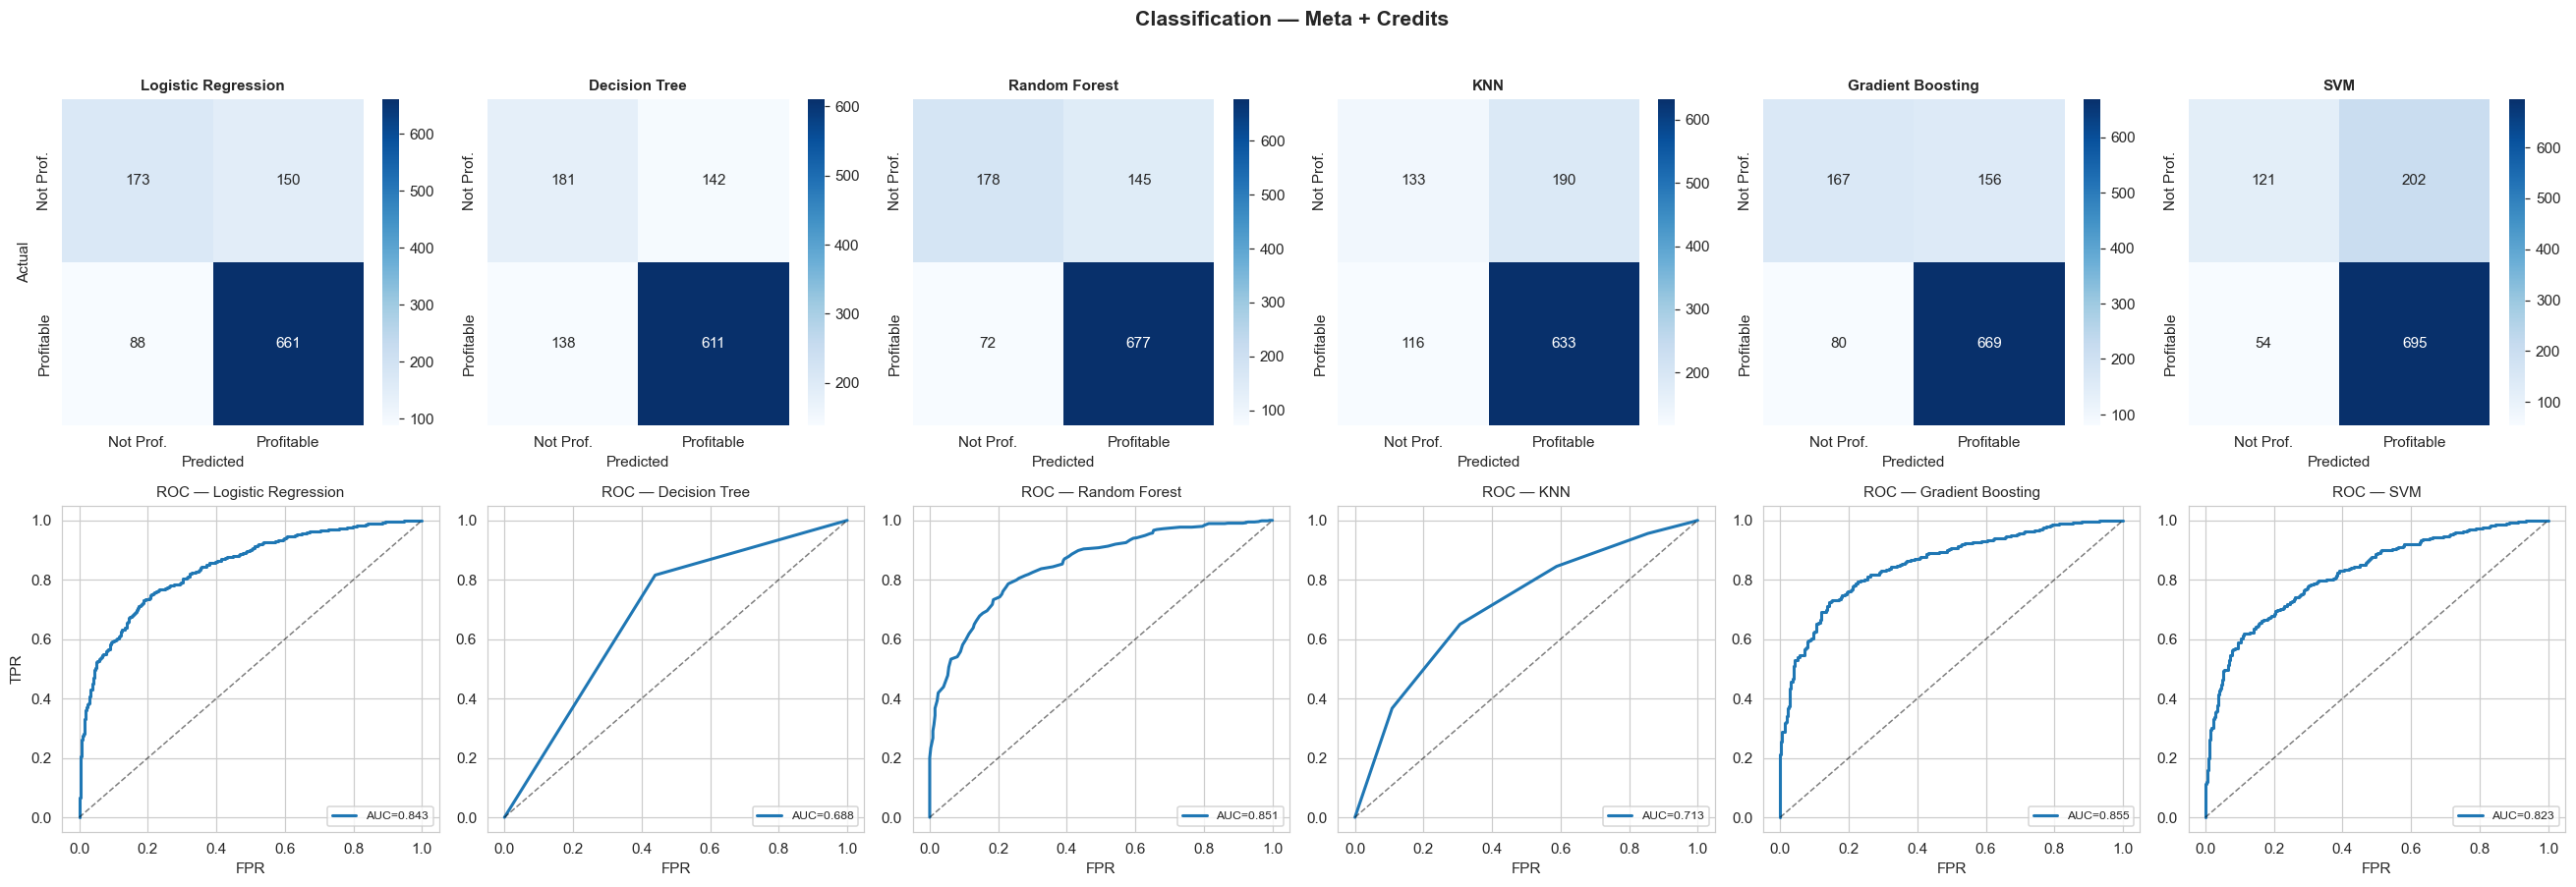

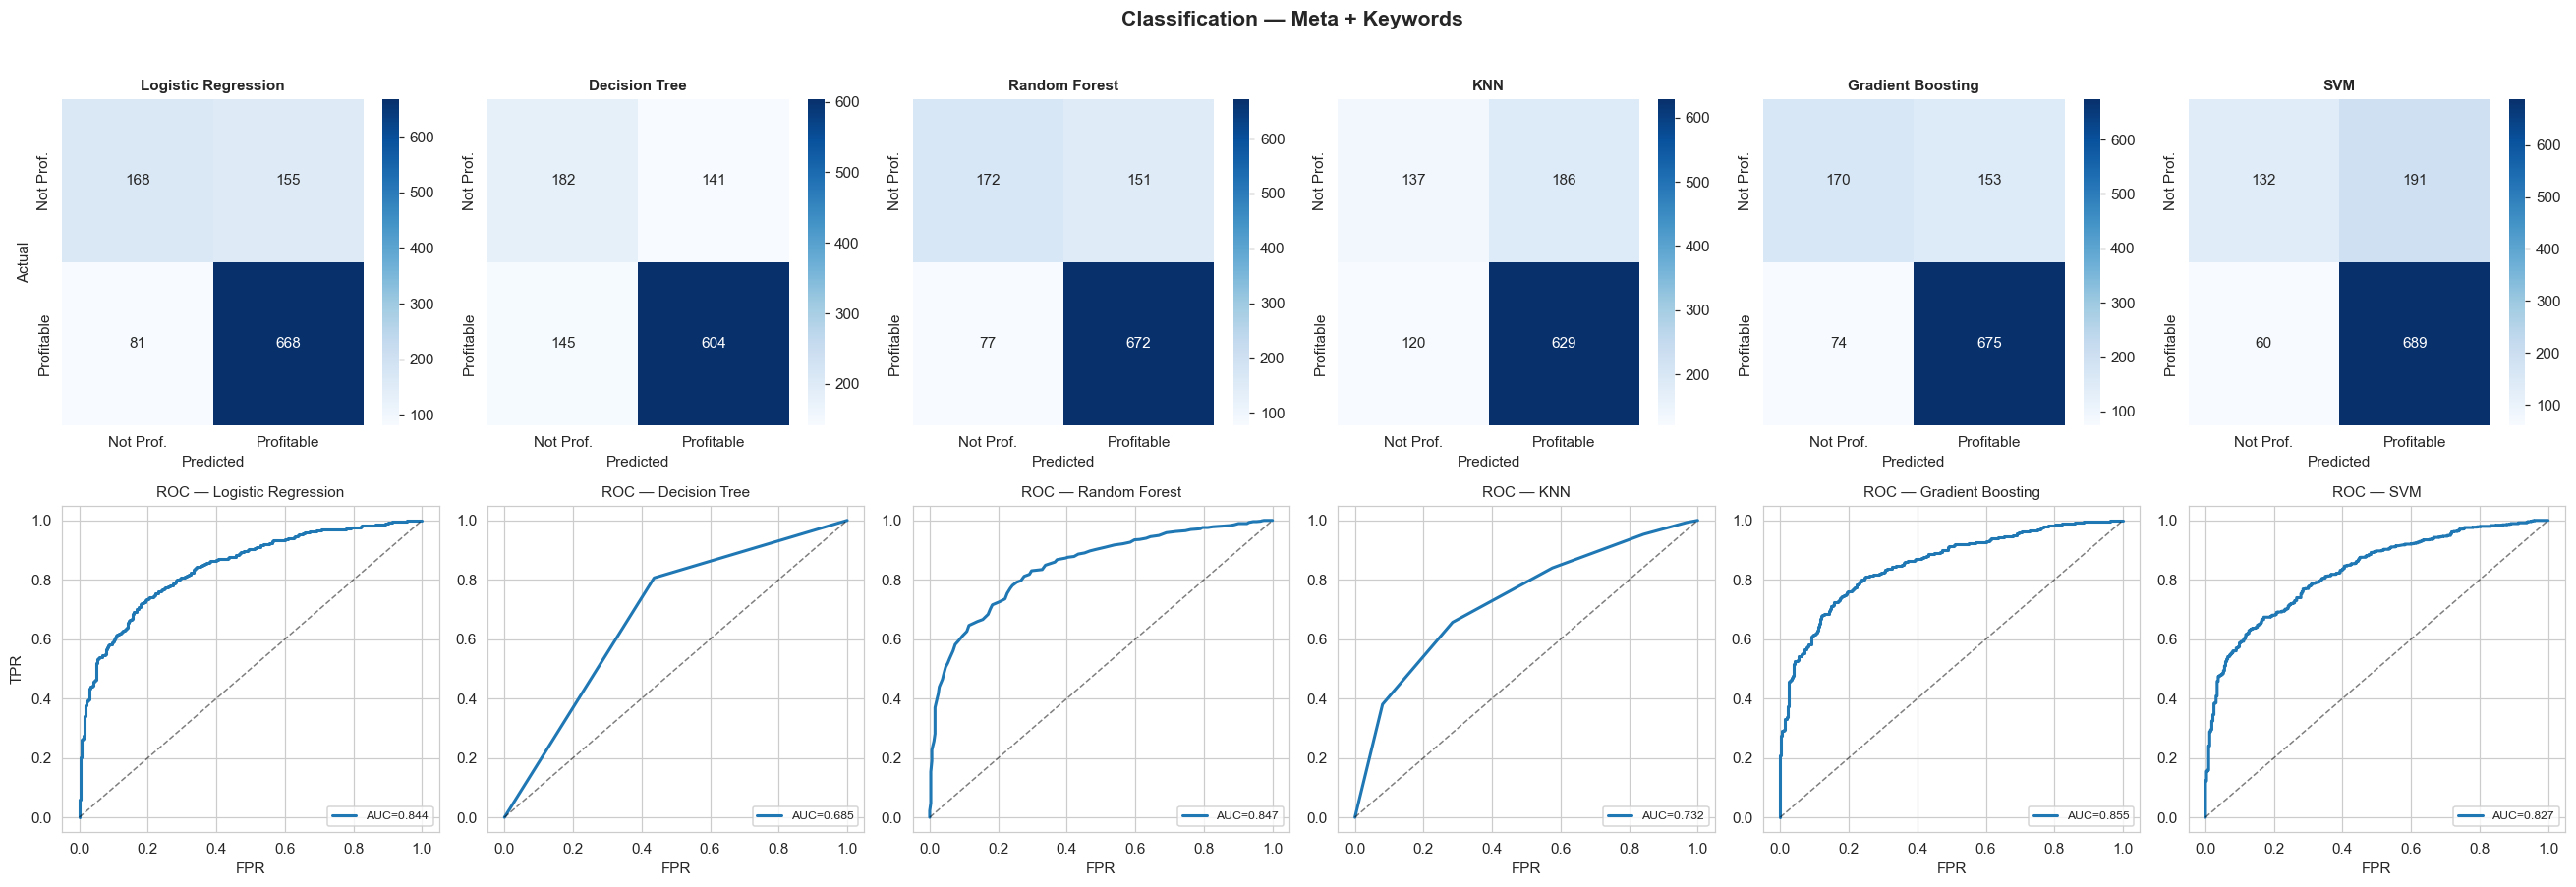

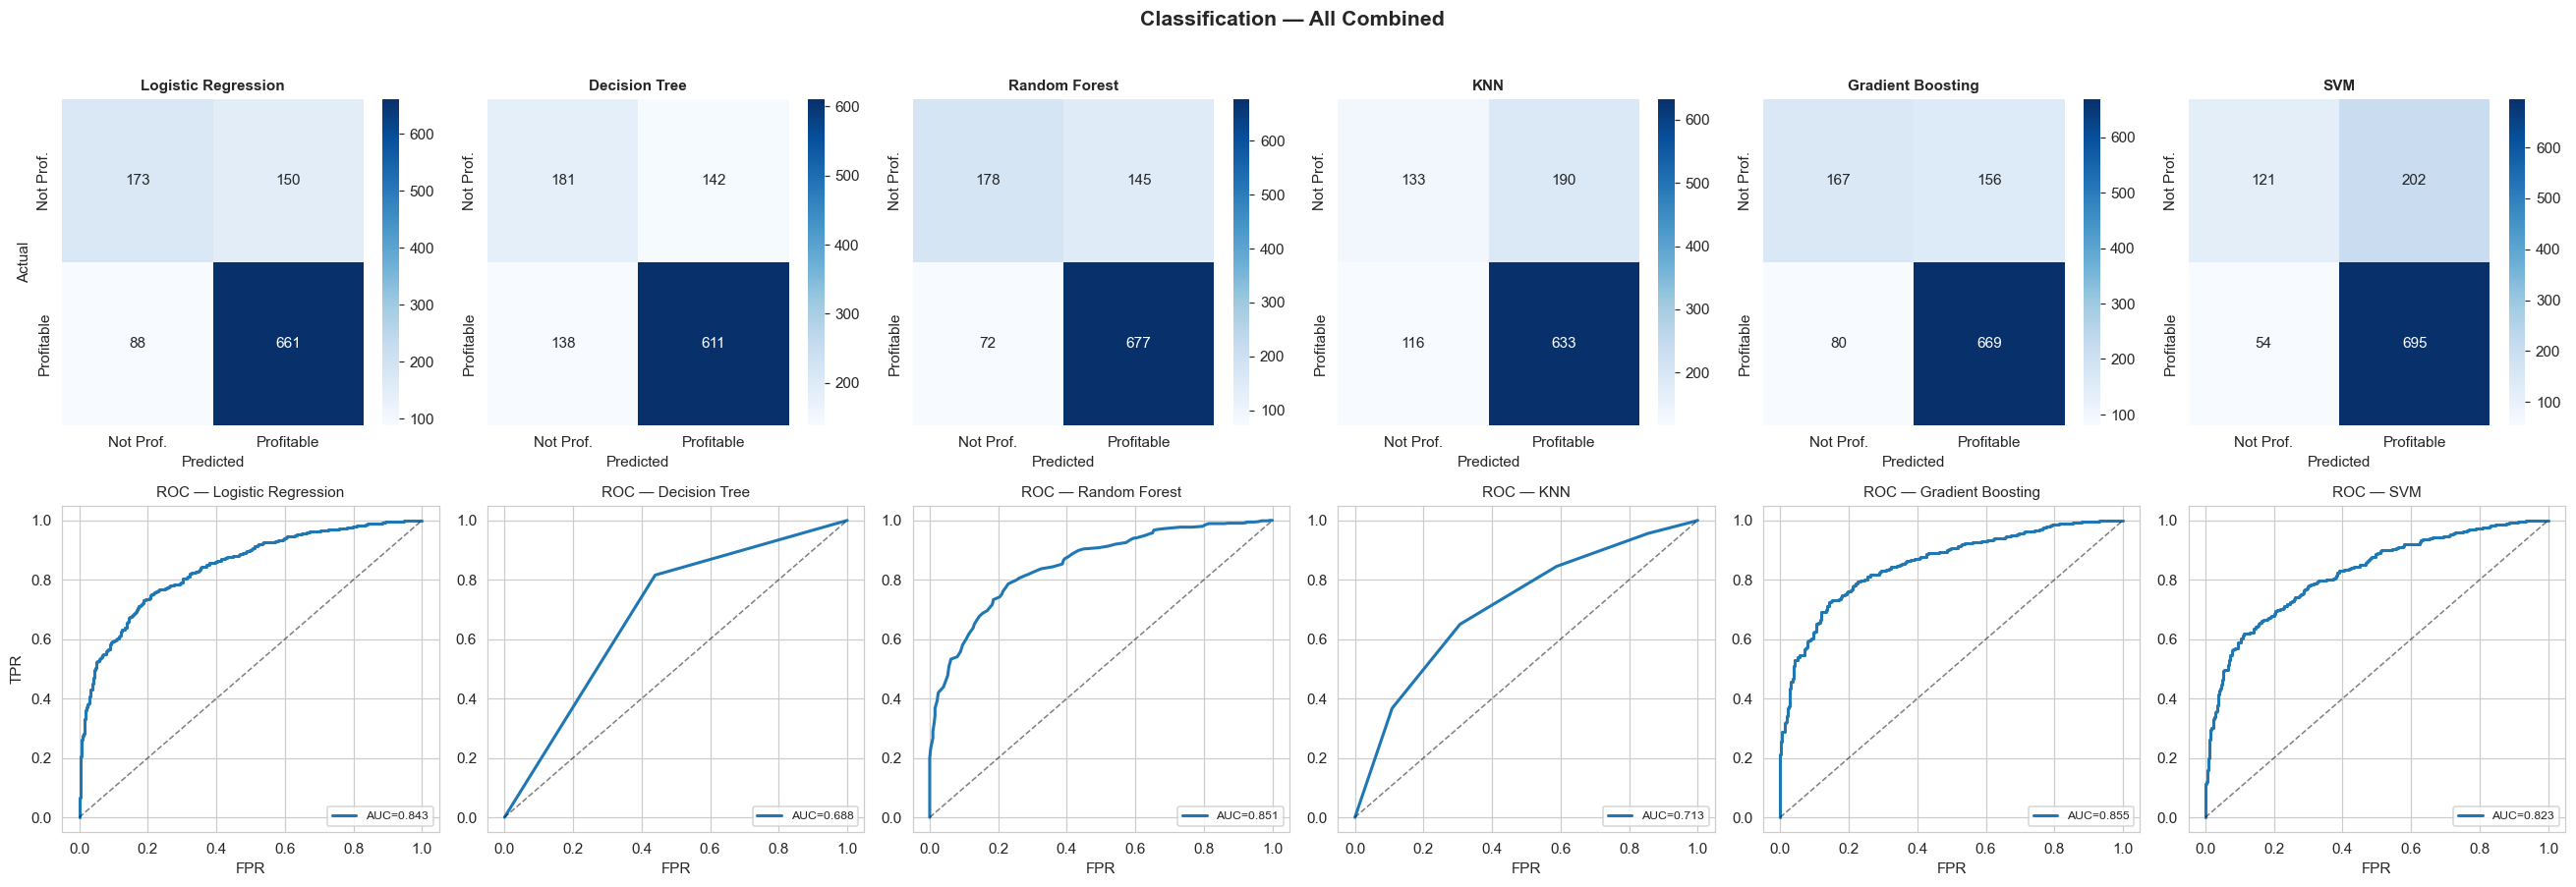

In [7]:
# Per-model confusion matrices + ROC curves (for each dataset variant)
for v in VARIANTS:
    yte = profit[v]['y_test']
    model_names_list = list(clf_models.keys())
    n = len(model_names_list)

    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))

    for j, name in enumerate(model_names_list):
        info = fitted_clf[v][name]
        y_pred, y_prob = info['y_pred'], info['y_prob']

        # Row 0: Confusion Matrix
        cm = confusion_matrix(yte, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, j],
                    xticklabels=['Not Prof.', 'Profitable'],
                    yticklabels=['Not Prof.', 'Profitable'])
        axes[0, j].set_title(f'{name}', fontsize=10, fontweight='bold')
        axes[0, j].set_ylabel('Actual' if j == 0 else '')
        axes[0, j].set_xlabel('Predicted')

        # Row 1: ROC Curve
        fpr, tpr, _ = roc_curve(yte, y_prob)
        auc_val = roc_auc_score(yte, y_prob)
        axes[1, j].plot(fpr, tpr, lw=2, label=f'AUC={auc_val:.3f}')
        axes[1, j].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        axes[1, j].set_xlabel('FPR')
        axes[1, j].set_ylabel('TPR' if j == 0 else '')
        axes[1, j].set_title(f'ROC — {name}', fontsize=10)
        axes[1, j].legend(fontsize=8, loc='lower right')

    fig.suptitle(f'Classification — {VARIANT_LABELS[v]}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 2.5 · Hyperparameter Tuning (Top 2 per Dataset)

In [8]:
param_grids_clf = {
    'Decision Tree': {'max_depth': [3, 5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'KNN': {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
}

tuned_clf_results = {}
for v in VARIANTS:
    cv_df = pd.DataFrame(all_cv_clf[v]).T
    top2 = cv_df['f1'].nlargest(2).index.tolist()
    print(f"\n{'='*70}")
    print(f"Tuning {VARIANT_LABELS[v]}: {top2}")
    print(f"{'='*70}")

    tuned_clf_results[v] = {}
    for name in top2:
        model_class = clf_models[name].__class__
        init_params = {'random_state': 42} if 'random_state' in clf_models[name].get_params() else {}
        grid = GridSearchCV(
            model_class(**init_params),
            param_grids_clf[name], cv=5, scoring='f1', n_jobs=-1, verbose=0
        )
        grid.fit(profit[v]['X_train'], profit[v]['y_train'])

        y_pred = grid.predict(profit[v]['X_test'])
        y_prob = (grid.predict_proba(profit[v]['X_test'])[:, 1]
                  if hasattr(grid, 'predict_proba')
                  else grid.decision_function(profit[v]['X_test']))
        test_f1 = f1_score(profit[v]['y_test'], y_pred)

        tuned_clf_results[v][name] = {
            'grid': grid,
            'best_params': grid.best_params_,
            'cv_f1': grid.best_score_,
            'test_f1': test_f1,
            'test_accuracy': accuracy_score(profit[v]['y_test'], y_pred),
            'test_roc_auc': roc_auc_score(profit[v]['y_test'], y_prob),
        }
        print(f"  {name}: CV F1={grid.best_score_:.4f}, Test F1={test_f1:.4f}")
        print(f"    Best params: {grid.best_params_}")


Tuning Metadata Only: ['Random Forest', 'Gradient Boosting']
  Random Forest: CV F1=0.8582, Test F1=0.8570
    Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
  Gradient Boosting: CV F1=0.8560, Test F1=0.8542
    Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

Tuning Meta + Credits: ['Random Forest', 'Gradient Boosting']
  Random Forest: CV F1=0.8591, Test F1=0.8526
    Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
  Gradient Boosting: CV F1=0.8569, Test F1=0.8560
    Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

Tuning Meta + Keywords: ['Random Forest', 'Gradient Boosting']
  Random Forest: CV F1=0.8577, Test F1=0.8552
    Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
  Gradient Boosting: CV F1=0.8541, Test F1=0.8570
    Best params: {'learning_rate': 0.01, 'max_depth'

### 2.6 · Select & Save Best Classifier per Dataset

In [9]:
os.makedirs('../models', exist_ok=True)
best_clf_models = {}

for v in VARIANTS:
    best_name = max(tuned_clf_results[v],
                    key=lambda m: tuned_clf_results[v][m]['test_f1'])
    best_info = tuned_clf_results[v][best_name]
    best_model = best_info['grid'].best_estimator_

    joblib.dump(best_model, f'../models/best_clf_model_{v}.pkl')
    best_clf_models[v] = {
        'name': best_name,
        'test_f1': best_info['test_f1'],
        'test_accuracy': best_info['test_accuracy'],
        'test_roc_auc': best_info['test_roc_auc'],
    }
    print(f"{VARIANT_LABELS[v]:20s} → {best_name}")
    print(f"  F1={best_info['test_f1']:.4f}  Acc={best_info['test_accuracy']:.4f}  AUC={best_info['test_roc_auc']:.4f}")
    print(f"  Saved: models/best_clf_model_{v}.pkl")

Metadata Only        → Random Forest
  F1=0.8570  Acc=0.7892  AUC=0.8544
  Saved: models/best_clf_model_metadata_only.pkl
Meta + Credits       → Gradient Boosting
  F1=0.8560  Acc=0.7901  AUC=0.8521
  Saved: models/best_clf_model_meta_+_credits.pkl
Meta + Keywords      → Gradient Boosting
  F1=0.8570  Acc=0.7873  AUC=0.8468
  Saved: models/best_clf_model_meta_+_keywords.pkl
All Combined         → Gradient Boosting
  F1=0.8560  Acc=0.7901  AUC=0.8521
  Saved: models/best_clf_model_all_combined.pkl


---
## 3 · Regression — Predict `vote_average`

### 3.1 · Cross-Validate All Models on All Dataset Variants

In [10]:
reg_models = {
    'Linear Regression':  LinearRegression(),
    'Decision Tree':      DecisionTreeRegressor(random_state=42),
    'Random Forest':      RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting':  GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR':                SVR(kernel='rbf'),
}

all_cv_reg = {}
for v in VARIANTS:
    Xtr, ytr = vote[v]['X_train'], vote[v]['y_train']
    print(f"\n--- {VARIANT_LABELS[v]} ({Xtr.shape[1]} features) ---")
    print(f"{'Model':<25} {'RMSE':>12} {'MAE':>12} {'R²':>12}  Time")
    print("-" * 75)

    cv_res = {}
    for name, model in reg_models.items():
        t0 = time.time()
        neg_mse = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='neg_mean_squared_error')
        mae_sc  = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='neg_mean_absolute_error')
        r2_sc   = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='r2')
        elapsed = time.time() - t0

        rmse_vals = np.sqrt(-neg_mse)
        mae_vals  = -mae_sc

        cv_res[name] = {
            'rmse': rmse_vals.mean(), 'rmse_std': rmse_vals.std(),
            'mae': mae_vals.mean(), 'mae_std': mae_vals.std(),
            'r2': r2_sc.mean(), 'r2_std': r2_sc.std(),
        }
        print(f"{name:<25} {rmse_vals.mean():.4f}±{rmse_vals.std():.3f}"
              f" {mae_vals.mean():.4f}±{mae_vals.std():.3f}"
              f" {r2_sc.mean():.4f}±{r2_sc.std():.3f}"
              f"  {elapsed:.1f}s")
    all_cv_reg[v] = cv_res


--- Metadata Only (33 features) ---
Model                             RMSE          MAE           R²  Time
---------------------------------------------------------------------------
Linear Regression         1.1760±0.007 0.8739±0.006 0.1325±0.006  0.3s
Decision Tree             1.5550±0.022 1.1301±0.013 -0.5167±0.031  2.8s
Random Forest             1.1051±0.008 0.7958±0.008 0.2340±0.009  20.0s
KNN                       1.2277±0.005 0.9158±0.005 0.0546±0.006  2.3s
Gradient Boosting         1.1032±0.007 0.8024±0.009 0.2366±0.004  38.3s
SVR                       1.1251±0.008 0.8142±0.006 0.2061±0.007  676.9s

--- Meta + Credits (35 features) ---
Model                             RMSE          MAE           R²  Time
---------------------------------------------------------------------------
Linear Regression         1.1754±0.008 0.8735±0.006 0.1334±0.006  0.3s
Decision Tree             1.5588±0.020 1.1302±0.012 -0.5241±0.025  3.4s
Random Forest             1.1006±0.010 0.7947±0.009 0.240

### 3.2 · CV Results Comparison

BEST REGRESSOR PER DATASET (by CV R²)
        Dataset        Best Model  CV RMSE  CV MAE  CV R²
  Metadata Only Gradient Boosting   1.1032  0.8024 0.2366
 Meta + Credits Gradient Boosting   1.1006  0.8012 0.2402
Meta + Keywords Gradient Boosting   1.1038  0.8028 0.2358
   All Combined     Random Forest   1.0984  0.7933 0.2432


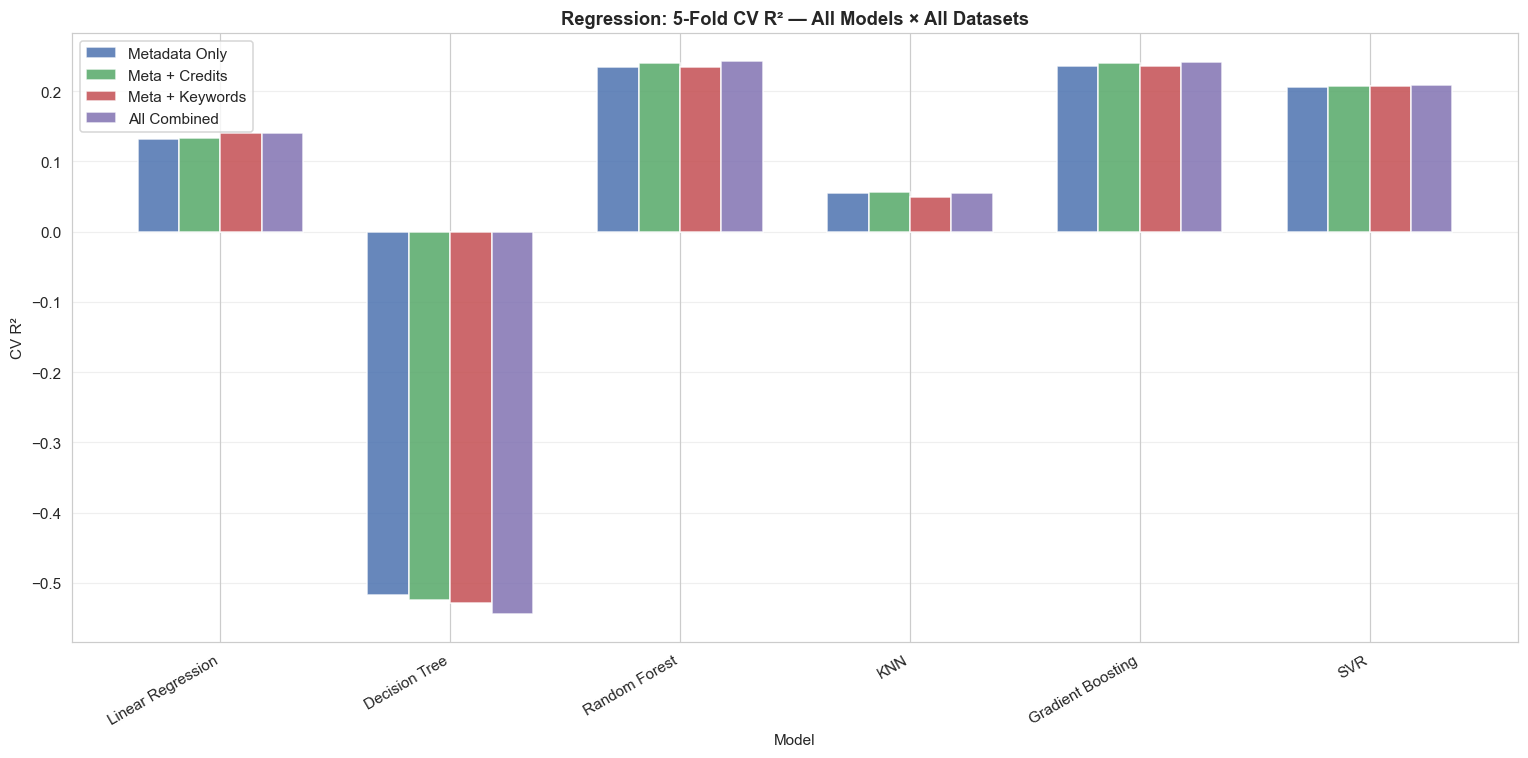

In [11]:
# Best regressor per dataset (by CV R²)
best_reg_cv = []
for v in VARIANTS:
    cv_res = all_cv_reg[v]
    best_name = max(cv_res, key=lambda m: cv_res[m]['r2'])
    best = cv_res[best_name]
    best_reg_cv.append({
        'Dataset': VARIANT_LABELS[v], 'Best Model': best_name,
        'CV RMSE': round(best['rmse'], 4),
        'CV MAE': round(best['mae'], 4), 'CV R²': round(best['r2'], 4),
    })

print("BEST REGRESSOR PER DATASET (by CV R²)")
print("=" * 80)
print(pd.DataFrame(best_reg_cv).to_string(index=False))

# Grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))
model_names_reg = list(reg_models.keys())
x = np.arange(len(model_names_reg))
width = 0.18

for i, v in enumerate(VARIANTS):
    r2_vals = [all_cv_reg[v][m]['r2'] for m in model_names_reg]
    ax.bar(x + i * width, r2_vals, width, label=VARIANT_LABELS[v], color=COLORS[i], alpha=0.85)

ax.set_xlabel('Model')
ax.set_ylabel('CV R²')
ax.set_title('Regression: 5-Fold CV R² — All Models × All Datasets', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names_reg, rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 · Test Set Evaluation — Per-Model Metrics

In [12]:
# Train on full train set, evaluate on test set — store fitted models
all_test_reg = {}
fitted_reg = {}

for v in VARIANTS:
    Xtr, Xte = vote[v]['X_train'], vote[v]['X_test']
    ytr, yte = vote[v]['y_train'], vote[v]['y_test']

    test_res = {}
    fitted_reg[v] = {}
    for name, model in reg_models.items():
        m = clone(model)
        m.fit(Xtr, ytr)
        y_pred = m.predict(Xte)

        test_res[name] = {
            'RMSE': np.sqrt(mean_squared_error(yte, y_pred)),
            'MAE':  mean_absolute_error(yte, y_pred),
            'R²':   r2_score(yte, y_pred),
        }
        fitted_reg[v][name] = {'model': m, 'y_pred': y_pred}
    all_test_reg[v] = test_res

for v in VARIANTS:
    print(f"\n--- {VARIANT_LABELS[v]} ---")
    test_df = pd.DataFrame(all_test_reg[v]).T
    test_df = test_df.sort_values('R²', ascending=False)
    print(test_df.round(4).to_string())


--- Metadata Only ---
                     RMSE     MAE      R²
Gradient Boosting  1.1328  0.8187  0.2258
Random Forest      1.1358  0.8085  0.2217
SVR                1.1510  0.8240  0.2006
Linear Regression  1.1928  0.8827  0.1415
KNN                1.2482  0.9238  0.0599
Decision Tree      1.5775  1.1343 -0.5015

--- Meta + Credits ---
                     RMSE     MAE      R²
Random Forest      1.1258  0.8050  0.2353
Gradient Boosting  1.1274  0.8147  0.2330
SVR                1.1478  0.8224  0.2051
Linear Regression  1.1928  0.8823  0.1415
KNN                1.2475  0.9243  0.0609
Decision Tree      1.5700  1.1273 -0.4872

--- Meta + Keywords ---
                     RMSE     MAE      R²
Random Forest      1.1312  0.8061  0.2279
Gradient Boosting  1.1329  0.8181  0.2256
SVR                1.1498  0.8225  0.2023
Linear Regression  1.1885  0.8764  0.1478
KNN                1.2466  0.9207  0.0624
Decision Tree      1.5864  1.1381 -0.5184

--- All Combined ---
                     RMS

### 3.4 · Per-Model Visualizations — Actual vs Predicted & Residuals

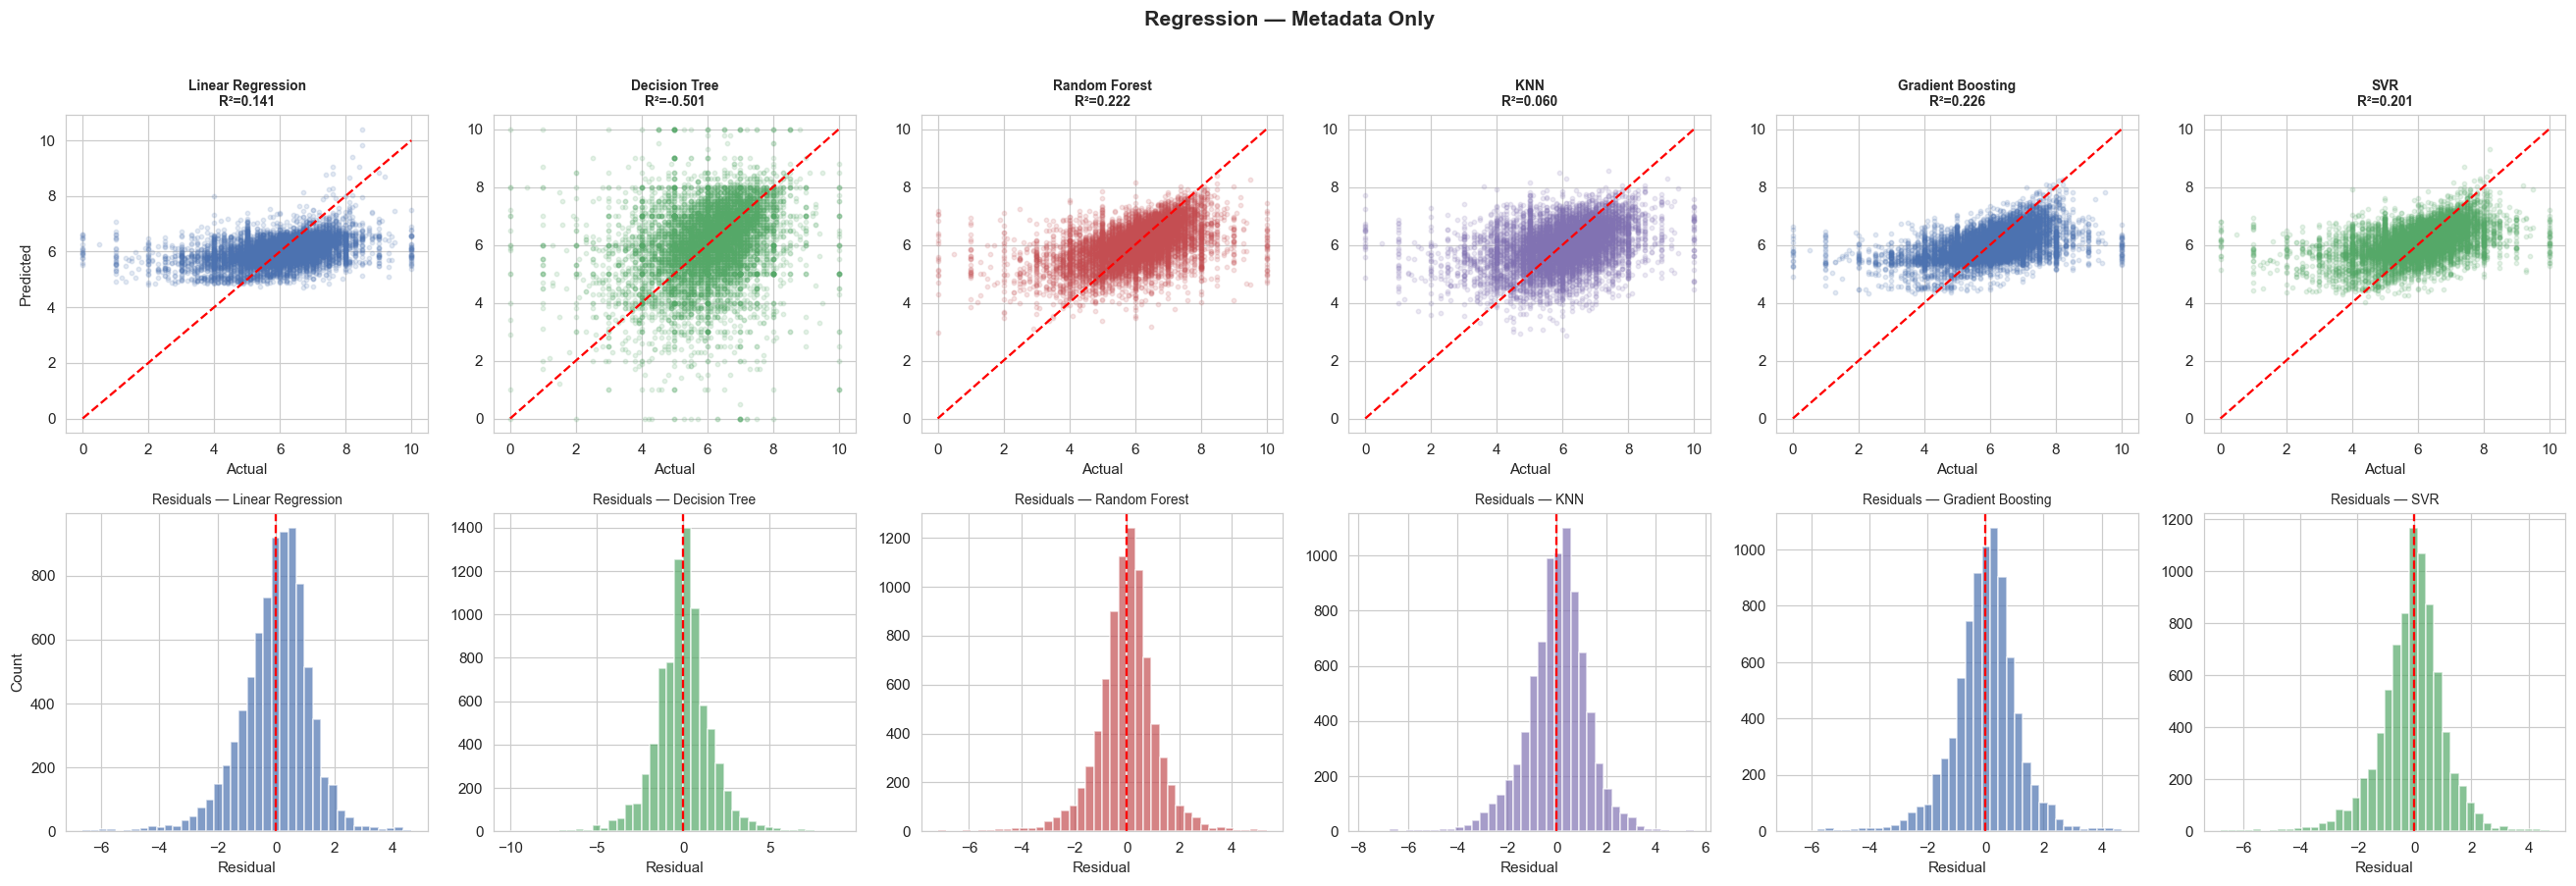

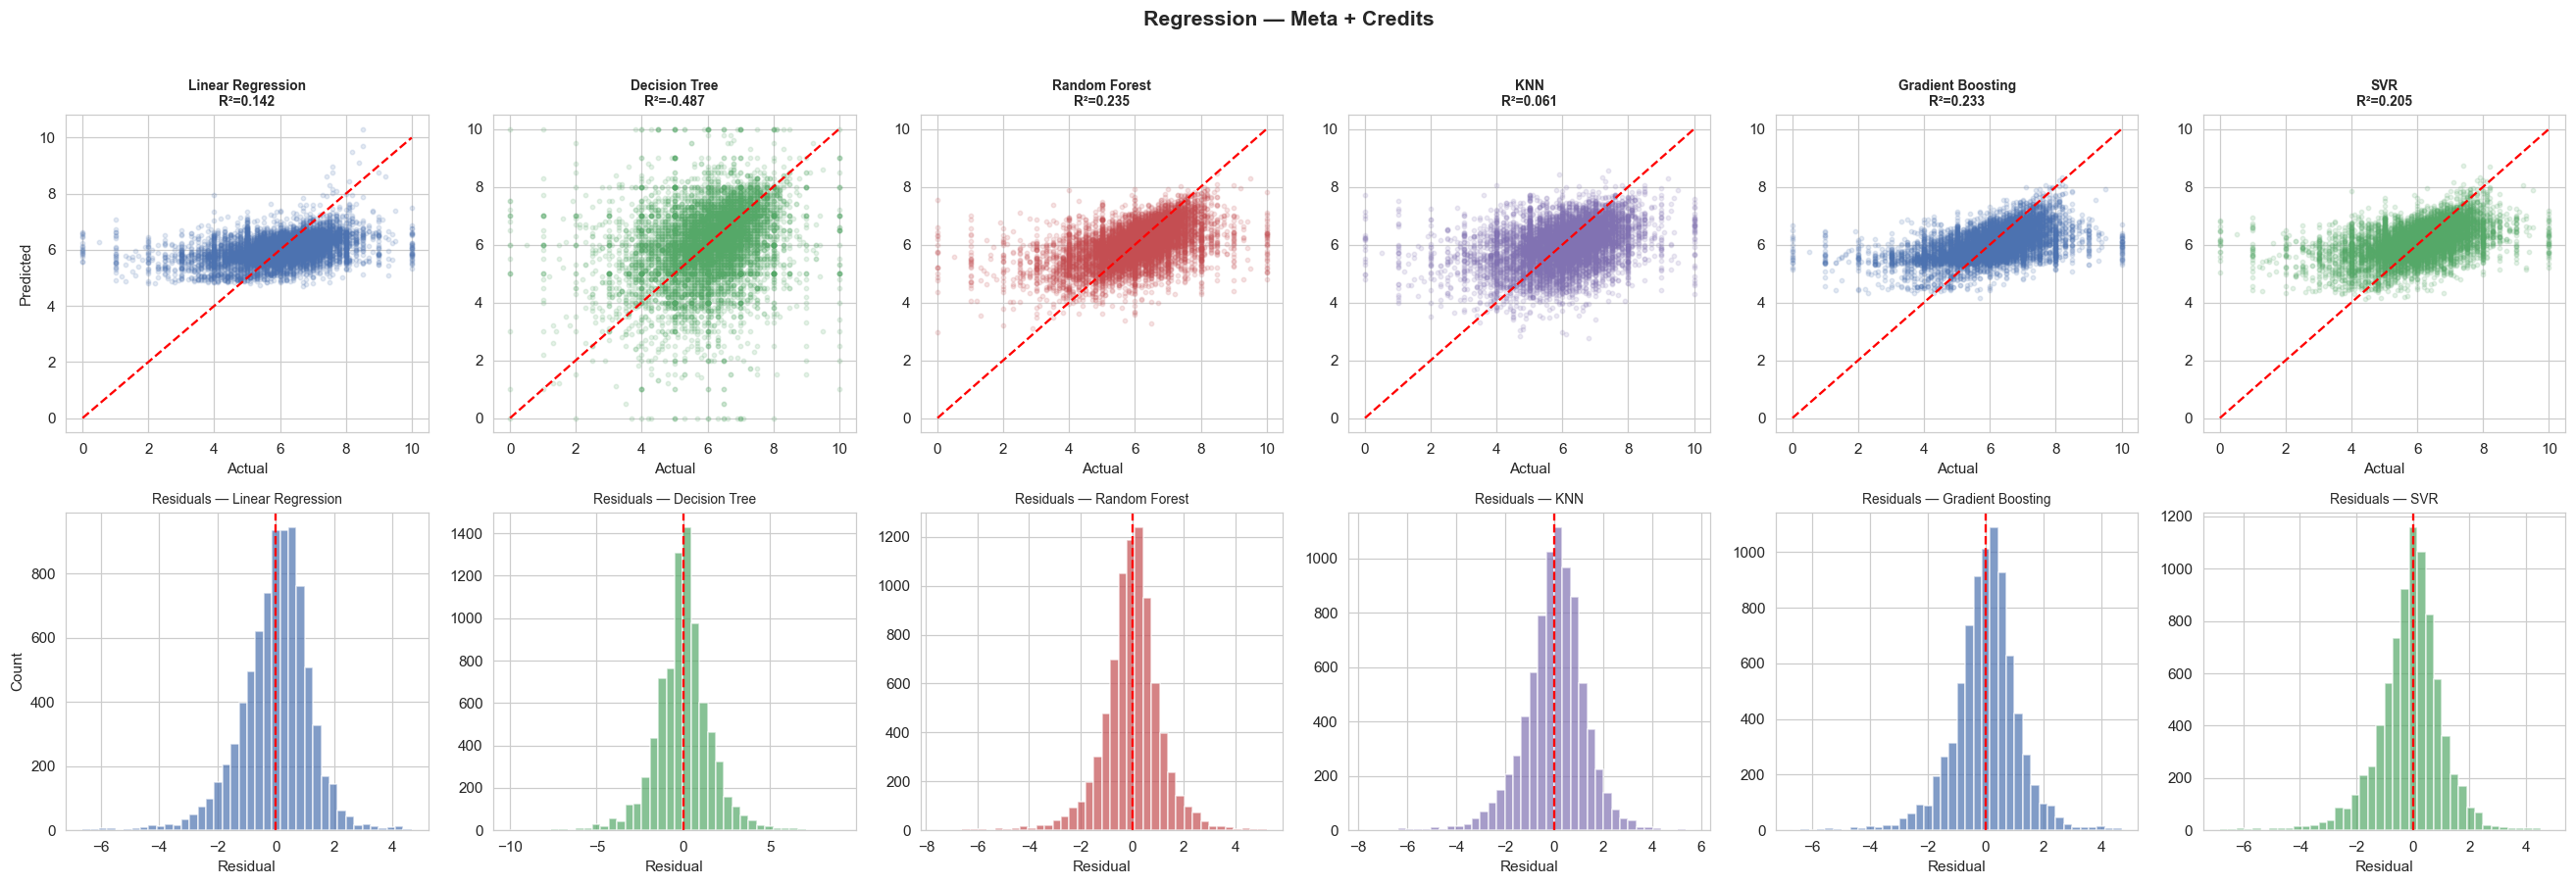

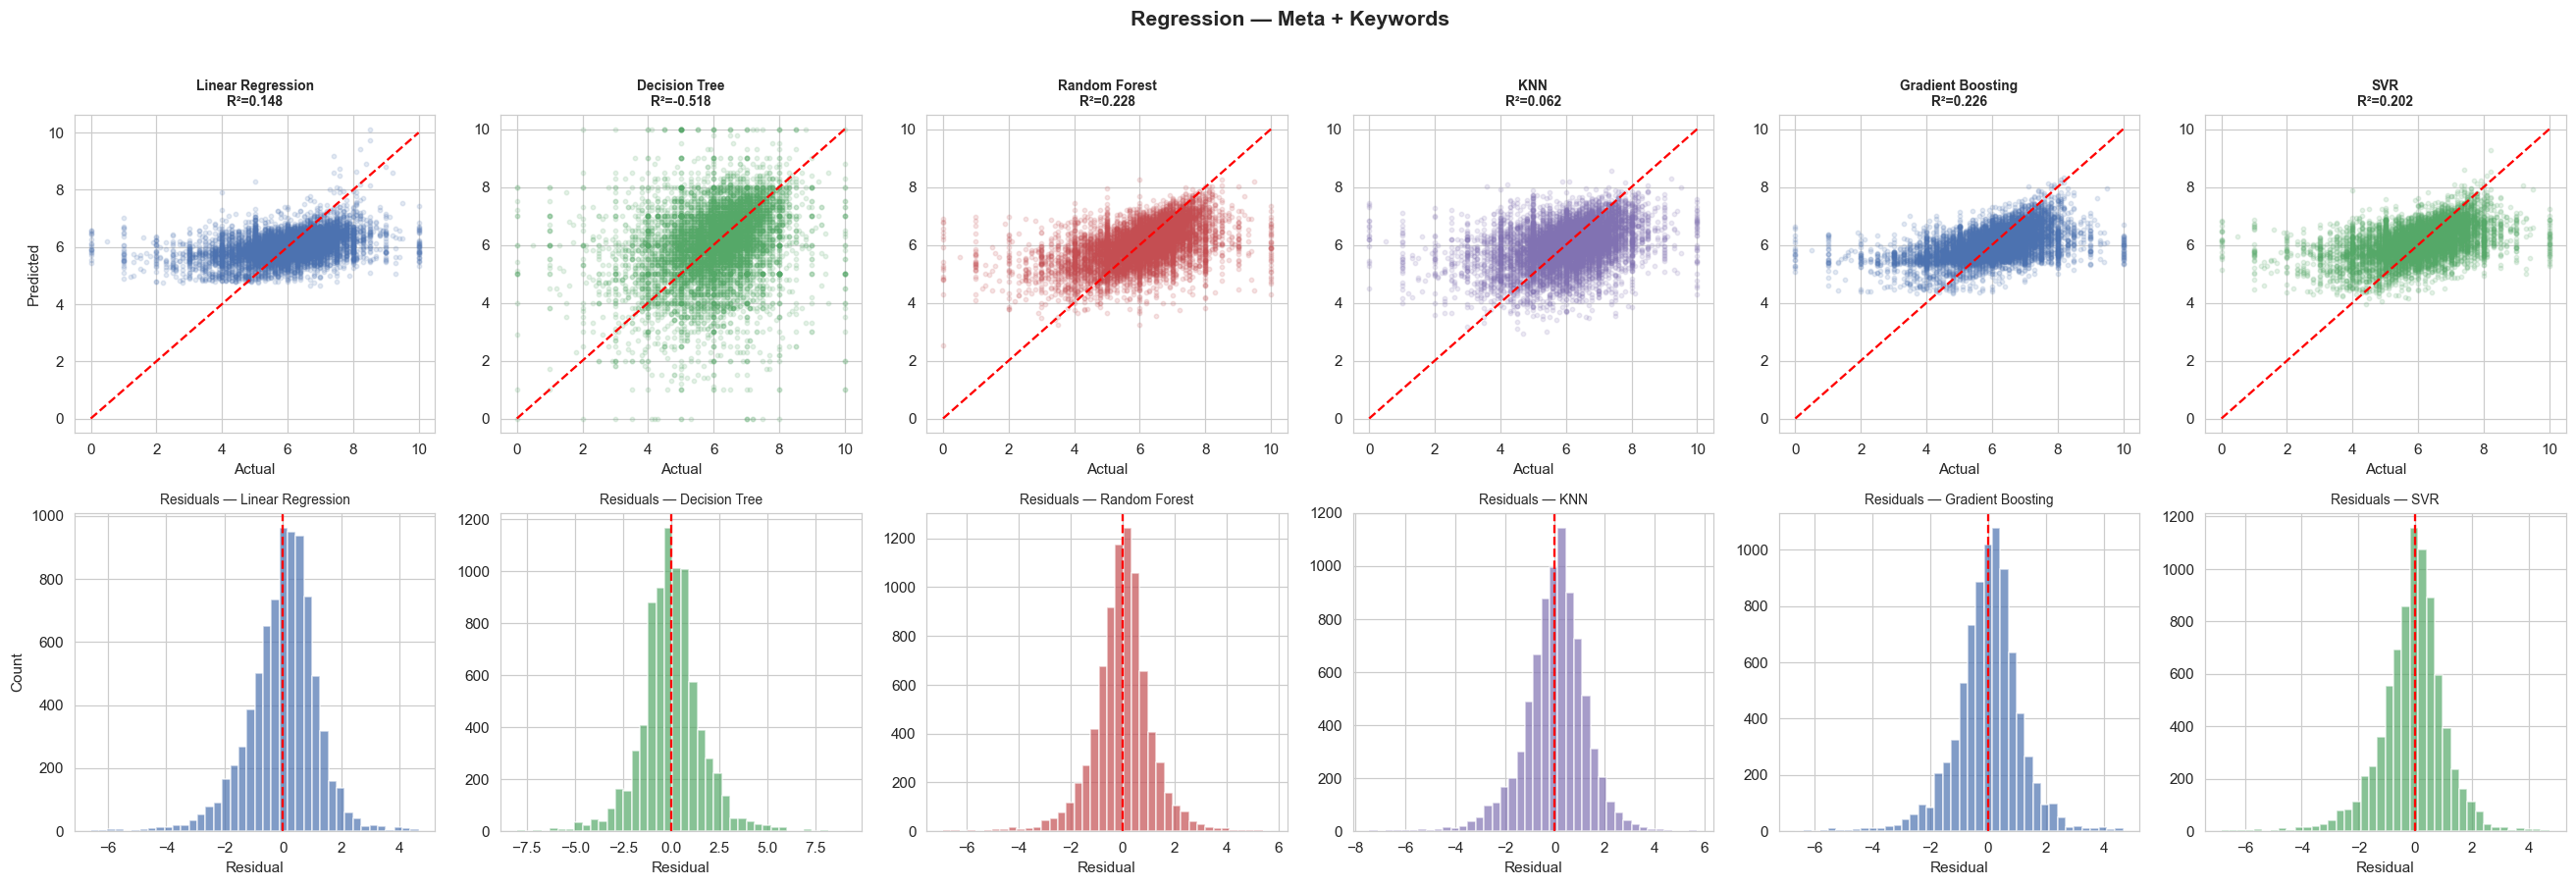

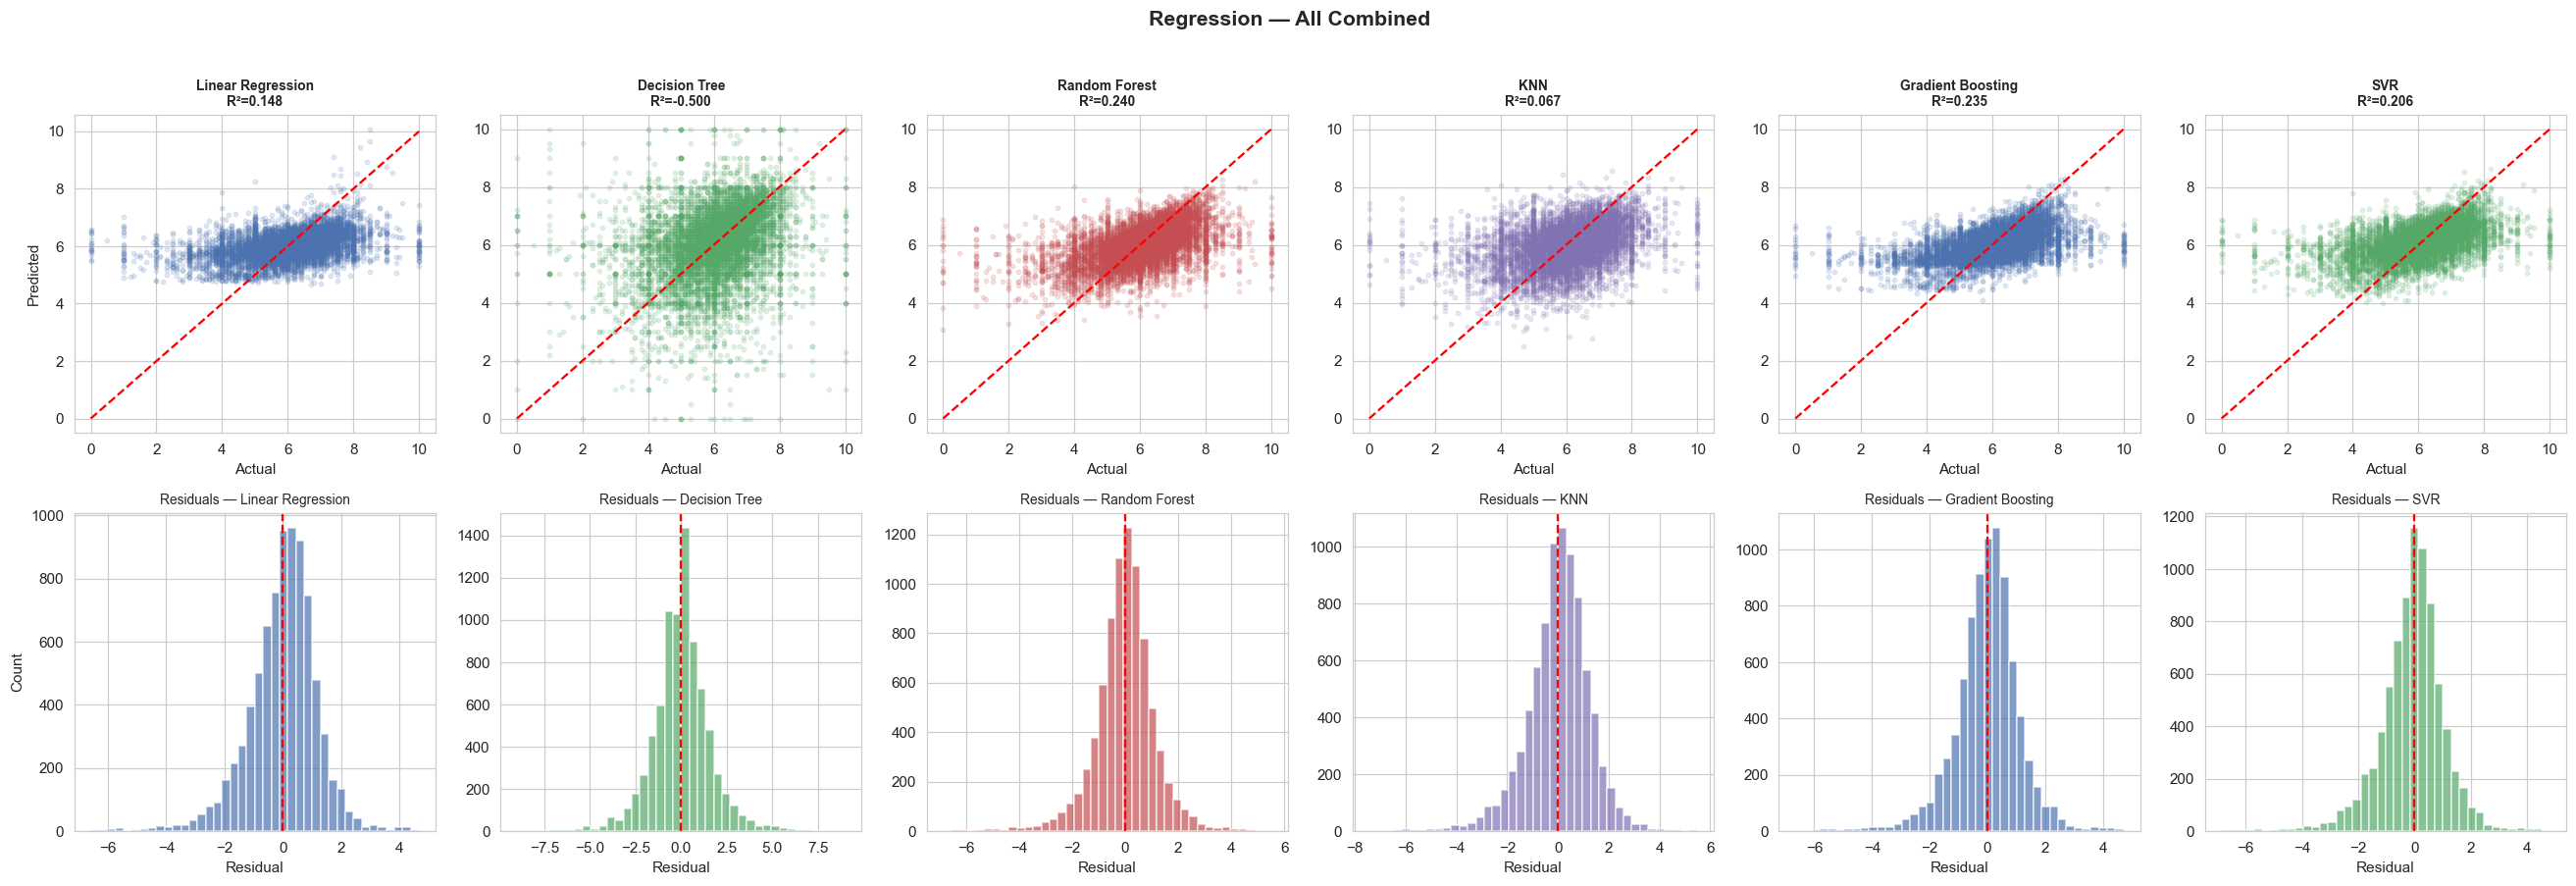

In [13]:
# Per-model: Actual vs Predicted scatter + Residual histogram (per dataset)
for v in VARIANTS:
    yte = vote[v]['y_test']
    model_names_list = list(reg_models.keys())
    n = len(model_names_list)

    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))

    for j, name in enumerate(model_names_list):
        y_pred = fitted_reg[v][name]['y_pred']
        residuals = yte.values - y_pred
        r2 = r2_score(yte, y_pred)

        # Row 0: Actual vs Predicted
        axes[0, j].scatter(yte, y_pred, alpha=0.15, s=8, color=COLORS[j % 4])
        mn, mx = yte.min(), yte.max()
        axes[0, j].plot([mn, mx], [mn, mx], 'r--', lw=1.5)
        axes[0, j].set_title(f'{name}\nR²={r2:.3f}', fontsize=9, fontweight='bold')
        axes[0, j].set_xlabel('Actual')
        axes[0, j].set_ylabel('Predicted' if j == 0 else '')

        # Row 1: Residual Distribution
        axes[1, j].hist(residuals, bins=40, color=COLORS[j % 4], alpha=0.7, edgecolor='white')
        axes[1, j].axvline(0, color='red', lw=1.5, ls='--')
        axes[1, j].set_title(f'Residuals — {name}', fontsize=9)
        axes[1, j].set_xlabel('Residual')
        axes[1, j].set_ylabel('Count' if j == 0 else '')

    fig.suptitle(f'Regression — {VARIANT_LABELS[v]}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 3.5 · Hyperparameter Tuning (Top 2 per Dataset)

In [16]:
param_grids_reg = {
    'Decision Tree': {'max_depth': [3, 5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'KNN': {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly']},
    'Linear Regression': {},
}

tuned_reg_results = {}
for v in VARIANTS:
    cv_df = pd.DataFrame(all_cv_reg[v]).T
    top2 = cv_df['r2'].nlargest(2).index.tolist()
    print(f"\n{'='*70}")
    print(f"Tuning {VARIANT_LABELS[v]}: {top2}")
    print(f"{'='*70}")

    tuned_reg_results[v] = {}
    for name in top2:
        if not param_grids_reg.get(name):
            print(f"  {name}: No hyperparameters to tune — using default.")
            m = clone(reg_models[name])
            m.fit(vote[v]['X_train'], vote[v]['y_train'])
            y_pred = m.predict(vote[v]['X_test'])
            tuned_reg_results[v][name] = {
                'model': m,
                'test_rmse': np.sqrt(mean_squared_error(vote[v]['y_test'], y_pred)),
                'test_mae': mean_absolute_error(vote[v]['y_test'], y_pred),
                'test_r2': r2_score(vote[v]['y_test'], y_pred),
            }
            continue

        model_class = reg_models[name].__class__
        init_params = {'random_state': 42} if 'random_state' in reg_models[name].get_params() else {}
        grid = GridSearchCV(
            model_class(**init_params),
            param_grids_reg[name], cv=5, scoring='r2', n_jobs=-1, verbose=0
        )
        grid.fit(vote[v]['X_train'], vote[v]['y_train'])

        y_pred = grid.predict(vote[v]['X_test'])
        test_rmse = np.sqrt(mean_squared_error(vote[v]['y_test'], y_pred))
        test_r2 = r2_score(vote[v]['y_test'], y_pred)

        tuned_reg_results[v][name] = {
            'model': grid.best_estimator_,
            'best_params': grid.best_params_,
            'cv_r2': grid.best_score_,
            'test_rmse': test_rmse,
            'test_mae': mean_absolute_error(vote[v]['y_test'], y_pred),
            'test_r2': test_r2,
        }
        print(f"  {name}: CV R²={grid.best_score_:.4f}, Test R²={test_r2:.4f}, Test RMSE={test_rmse:.4f}")
        print(f"    Best params: {grid.best_params_}")


Tuning Metadata Only: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.2582, Test R²=0.2508, Test RMSE=1.1143
    Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
  Random Forest: CV R²=0.2495, Test R²=0.2362, Test RMSE=1.1251
    Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Tuning Meta + Credits: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.2615, Test R²=0.2643, Test RMSE=1.1042
    Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Random Forest: CV R²=0.2538, Test R²=0.2462, Test RMSE=1.1177
    Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Tuning Meta + Keywords: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.2581, Test R²=0.2577, Test RMSE=1.1092
    Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Random Forest: CV R²=0.2512, Test R²=0.2

### 3.6 · Select & Save Best Regressor per Dataset

In [ ]:
best_reg_models = {}

for v in VARIANTS:
    best_name = max(tuned_reg_results[v],
                    key=lambda m: tuned_reg_results[v][m]['test_r2'])
    best_info = tuned_reg_results[v][best_name]
    best_model = best_info['model']

    joblib.dump(best_model, f'../models/best_reg_model_{v}.pkl')
    best_reg_models[v] = {
        'name': best_name,
        'test_rmse': best_info['test_rmse'],
        'test_mae': best_info['test_mae'],
        'test_r2': best_info['test_r2'],
    }
    print(f"{VARIANT_LABELS[v]:20s} → {best_name}")
    print(f"  RMSE={best_info['test_rmse']:.4f}  MAE={best_info['test_mae']:.4f}  R²={best_info['test_r2']:.4f}")
    print(f"  Saved: models/best_reg_model_{v}.pkl")

### 3.7 · Ensemble Averaging — Combine Top-3 Regressors

Average the predictions from the top-3 regressors (by test R²) to create an ensemble model. This reduces variance and often outperforms any single model.

In [ ]:
ensemble_results = {}

for v in VARIANTS:
    yte = vote[v]['y_test']

    # Rank all 6 models by test R²
    ranked = sorted(all_test_reg[v].items(), key=lambda x: x[1]['R²'], reverse=True)
    top3_names = [name for name, _ in ranked[:3]]
    print(f"\n--- {VARIANT_LABELS[v]} ---")
    print(f"  Top-3 models: {top3_names}")

    # Average their predictions
    preds = np.column_stack([fitted_reg[v][name]['y_pred'] for name in top3_names])
    y_ensemble = preds.mean(axis=1)

    ens_rmse = np.sqrt(mean_squared_error(yte, y_ensemble))
    ens_mae  = mean_absolute_error(yte, y_ensemble)
    ens_r2   = r2_score(yte, y_ensemble)

    # Compare with single-best
    single_best_name = ranked[0][0]
    single_best_r2 = ranked[0][1]['R²']

    ensemble_results[v] = {
        'top3': top3_names,
        'rmse': ens_rmse, 'mae': ens_mae, 'r2': ens_r2,
        'y_pred': y_ensemble,
    }

    delta = ens_r2 - single_best_r2
    arrow = '▲' if delta > 0 else '▼' if delta < 0 else '='
    print(f"  Ensemble:     RMSE={ens_rmse:.4f}  MAE={ens_mae:.4f}  R²={ens_r2:.4f}")
    print(f"  Single best:  R²={single_best_r2:.4f} ({single_best_name})")
    print(f"  Improvement:  {arrow} {abs(delta):.4f}")

# Summary table
print(f"\n{'='*80}")
print("ENSEMBLE vs SINGLE-BEST COMPARISON")
print("=" * 80)
comp_rows = []
for v in VARIANTS:
    ranked = sorted(all_test_reg[v].items(), key=lambda x: x[1]['R²'], reverse=True)
    comp_rows.append({
        'Dataset': VARIANT_LABELS[v],
        'Single Best': ranked[0][0],
        'Single R²': round(ranked[0][1]['R²'], 4),
        'Ensemble R²': round(ensemble_results[v]['r2'], 4),
        'Delta': round(ensemble_results[v]['r2'] - ranked[0][1]['R²'], 4),
    })
print(pd.DataFrame(comp_rows).to_string(index=False))

In [ ]:
# Visualize ensemble vs individual for each dataset
fig, axes = plt.subplots(1, len(VARIANTS), figsize=(6 * len(VARIANTS), 5))

for i, v in enumerate(VARIANTS):
    ax = axes[i]
    yte = vote[v]['y_test']
    y_ens = ensemble_results[v]['y_pred']

    # Scatter: Actual vs Ensemble predicted
    ax.scatter(yte, y_ens, alpha=0.15, s=8, color='#2ca02c', label='Ensemble')
    mn, mx = yte.min(), yte.max()
    ax.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
    ax.set_title(f'{VARIANT_LABELS[v]}\nEnsemble R²={ensemble_results[v]["r2"]:.3f}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual vote_average')
    ax.set_ylabel('Predicted (Ensemble Avg)' if i == 0 else '')
    ax.legend(fontsize=8)

plt.suptitle('Ensemble (Top-3 Avg) — Actual vs Predicted', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

# Save ensemble models (save the top-3 fitted models as a list)
for v in VARIANTS:
    top3 = ensemble_results[v]['top3']
    ens_models = [fitted_reg[v][name]['model'] for name in top3]
    joblib.dump({'models': ens_models, 'names': top3},
                f'../models/ensemble_reg_{v}.pkl')
    print(f"  Saved ensemble for {VARIANT_LABELS[v]}: models/ensemble_reg_{v}.pkl")

---
## 4 · Cross-Dataset Summary

In [ ]:
# Final comparison across all datasets
print("CLASSIFICATION — Best Tuned Model per Dataset")
print("=" * 80)
clf_comp = []
for v in VARIANTS:
    info = best_clf_models[v]
    clf_comp.append({
        'Dataset': VARIANT_LABELS[v],
        'Best Model': info['name'],
        'Test Accuracy': round(info['test_accuracy'], 4),
        'Test F1': round(info['test_f1'], 4),
        'Test ROC-AUC': round(info['test_roc_auc'], 4),
    })
print(pd.DataFrame(clf_comp).to_string(index=False))

print("\n\nREGRESSION — Best Single + Ensemble per Dataset")
print("=" * 80)
reg_comp = []
for v in VARIANTS:
    info = best_reg_models[v]
    ens = ensemble_results[v]
    reg_comp.append({
        'Dataset': VARIANT_LABELS[v],
        'Best Single': info['name'],
        'Single R²': round(info['test_r2'], 4),
        'Single RMSE': round(info['test_rmse'], 4),
        'Ensemble R²': round(ens['r2'], 4),
        'Ensemble RMSE': round(ens['rmse'], 4),
    })
print(pd.DataFrame(reg_comp).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ds_labels_list = [VARIANT_LABELS[v] for v in VARIANTS]

# Classification F1
f1_vals = [best_clf_models[v]['test_f1'] for v in VARIANTS]
axes[0].barh(ds_labels_list, f1_vals, color=COLORS, alpha=0.85)
axes[0].set_xlabel('Test F1')
axes[0].set_title('Best Classifier (Profit)', fontweight='bold')
for i, val in enumerate(f1_vals):
    axes[0].text(val + 0.003, i, f'{val:.3f}', va='center', fontsize=10)

# Regression R² — Single Best
r2_single = [best_reg_models[v]['test_r2'] for v in VARIANTS]
axes[1].barh(ds_labels_list, r2_single, color=COLORS, alpha=0.85)
axes[1].set_xlabel('Test R²')
axes[1].set_title('Best Single Regressor (Vote)', fontweight='bold')
for i, val in enumerate(r2_single):
    axes[1].text(val + 0.003, i, f'{val:.3f}', va='center', fontsize=10)

# Regression R² — Ensemble
r2_ens = [ensemble_results[v]['r2'] for v in VARIANTS]
axes[2].barh(ds_labels_list, r2_ens, color=COLORS, alpha=0.85)
axes[2].set_xlabel('Test R²')
axes[2].set_title('Ensemble Top-3 Avg (Vote)', fontweight='bold')
for i, val in enumerate(r2_ens):
    axes[2].text(val + 0.003, i, f'{val:.3f}', va='center', fontsize=10)

plt.suptitle('Cross-Dataset Comparison — Best Tuned Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Summary

### Models Trained (6 per task × 4 dataset variants)

| Classification (Profit) | Regression (Vote) |
|---|---|
| Logistic Regression | Linear Regression |
| Decision Tree | Decision Tree |
| Random Forest | Random Forest |
| KNN | KNN |
| Gradient Boosting | Gradient Boosting |
| SVM | SVR |

### Per-Model Visualizations
- **Classification:** Confusion matrices + ROC curves for all 6 models per dataset
- **Regression:** Actual-vs-Predicted scatter + Residual histograms for all 6 models per dataset

### Ensemble Averaging (Regression)
- Average predictions from top-3 regressors per dataset variant
- Compared single-best vs ensemble R² to assess improvement

### Saved Artifacts (per dataset variant)
| File | Description |
|------|-------------|
| `models/best_clf_model_{variant}.pkl` | Best tuned classifier (profitable) |
| `models/best_reg_model_{variant}.pkl` | Best tuned single regressor (vote_average) |
| `models/ensemble_reg_{variant}.pkl` | Top-3 ensemble regressors |
| `models/scaler_clf_profit_{variant}.pkl` | StandardScaler for classification |
| `models/scaler_reg_vote_{variant}.pkl` | StandardScaler for regression |

### Next Steps
1. **Notebook 05** — Advanced improvements (XGBoost, LightGBM, feature selection, class imbalance)
2. Compare improvements across all dataset variants